In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, DepthwiseConv2D
#keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

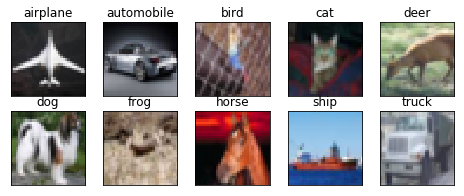

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Shared Input Layer
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

# input layer
visible = Input(shape=(32,32,3))


# Normal Convolution
conv1 = Conv2D(32, 3, 3 , border_mode='same',activation='relu')(visible) #3

# Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
conv1 = Conv2D(64, 3,1, dilation_rate=3, border_mode='same' ,activation='relu' )(conv1) #3
conv1 = Conv2D(64, 1,3, dilation_rate=3, border_mode='same' ,activation='relu' )(conv1)  #5
conv1 = Dropout(0.25)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #10

# Depthwise Separable Convolution
conv1 = DepthwiseConv2D(32, 3, dilation_rate=2, padding='same', activation='relu')(pool1) #12
conv1 = Dropout(0.25)(conv1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv1) #24


# Grouped Convolution (use 3x3, 5x5 only)
conv2 = Conv2D(16 , (3,3), padding='same' ,activation='relu')(pool2)
conv2 = Conv2D(16 , (5,5), padding='same' ,activation='relu')(conv2) #26
conv2 = Dropout(0.25)(conv2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv2) #


#------------------------------------------------------------------------------>
#Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)

conv3 = Conv2D(16 , (3,3), dilation_rate=1, padding='same' ,activation='relu')(pool2)
conv3 = Conv2D(16 , (3,3), dilation_rate=2, padding='same' ,activation='relu')(conv3)
conv3 = Dropout(0.25)(conv3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)

# merge Grouped Convolution
merge = concatenate([pool3, pool4])

# interpretation layer
output = Conv2D(10 ,1 ,activation='relu')(merge)
output = Flatten()(output)

#model defination
model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='shared_input_layer.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), dilation_rate=3, activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), dilation_rate=3, activation="relu", padding="same")`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 64)   6208        conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 64)   12352       conv2d_10[0][0]                  
__________________________________________________________________________________________________
dropout_5 

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0616 08:08:45.192527 140596847630208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0616 08:08:45.240297 140596847630208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
for layer in model.layers:
    print(layer.input_shape)
    print(layer.name)
#     print(layer)

In [0]:
# plot_model(model, to_file='drive/shared_input_layer.png')

Epoch 1/50
  1/390 [..............................] - ETA: 45s - loss: 4.6823 - acc: 0.1406

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


390/390 [==============================] - 51s 132ms/step - loss: 2.9678 - acc: 0.1709 - val_loss: 3.4937 - val_acc: 0.1786
Epoch 2/50
390/390 [==============================] - 52s 132ms/step - loss: 2.2777 - acc: 0.2188 - val_loss: 1.9068 - val_acc: 0.2932
Epoch 3/50
390/390 [==============================] - 51s 131ms/step - loss: 2.2718 - acc: 0.1978 - val_loss: 2.2794 - val_acc: 0.1324
Epoch 4/50
390/390 [==============================] - 51s 131ms/step - loss: 2.2274 - acc: 0.1556 - val_loss: 2.3029 - val_acc: 0.0996
Epoch 5/50
390/390 [==============================] - 51s 131ms/step - loss: 2.2875 - acc: 0.1201 - val_loss: 2.2043 - val_acc: 0.1662
Epoch 6/50
390/390 [==============================] - 51s 131ms/step - loss: 2.2113 - acc: 0.1672 - val_loss: 2.2820 - val_acc: 0.1367
Epoch 7/50
390/390 [==============================] - 51s 132ms/step - loss: 2.1743 - acc: 0.1776 - val_loss: 2.0208 - val_acc: 0.2513
Epoch 8/50
390/390 [==============================] - 51s 131ms/st

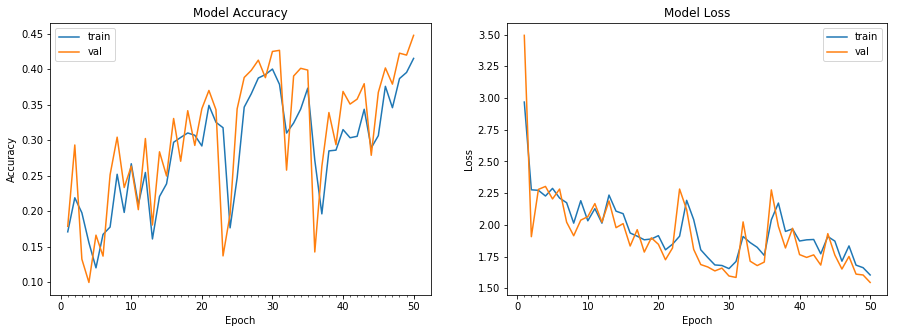

Accuracy on test data is: 44.76


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

NameError: ignored